In [2]:
# edo eimai, predict XYZ coords in collision. write them in the thesis. Watch out the last layer. It is linear.
# 2) Predict exact collision time.
# 3) Predict relative move rnn
# 4) use kans
# i am trying to perform normalization here. not working....

from pathlib import Path
import sys
sys.path.insert(0, "C:\\Users\geork\projects\AIThesis\src\src")
import matplotlib.pyplot as plt

from dataset_reader import DatasetReaderCSV

In [3]:
path = Path("C:\\Users\\geork\\projects\\AIThesis\\src\\analysis\\ThesisChapters\\5_3\\dataset.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Id", "Position", "Path", "GifPath", "Head_Collision_X", "Head_Collision_Y", "Head_Collision_Z", "CarProfile"], errors="ignore")

In [4]:
print(df.dtypes)

Velocity                    int64
Translation                 int64
Rotation                    int64
Head_Collision_XYZ_index    int64
Bumber_Height               int64
Front_Hood_Height           int64
Bumber_Hood_Angle           int64
Hood_Length                 int64
Back_Hood_Height            int64
dtype: object


In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Assuming df is your DataFrame
# Define features (X) and targets (y)
X = df.drop(columns=['Head_Collision_XYZ_index'])
y = df[['Head_Collision_XYZ_index']]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

In [4]:
inputs_names = X.columns.tolist()

In [6]:
import torch

dataset = {}
dataset['train_input'] = torch.tensor(X_train, dtype=torch.float32)
dataset['train_label'] = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
dataset['test_input'] = torch.tensor(X_test, dtype=torch.float32)
dataset['test_label'] = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
#nomizo prepei na ftiakso ena dataset me kleidia train_input kai train_label kai na to peraso sto model.s
print("Train data shape: {}".format(dataset['train_input'].shape))
print("Train target shape: {}".format(dataset['train_label'].shape))
print("Test data shape: {}".format(dataset['test_input'].shape))
print("Test target shape: {}".format(dataset['test_label'].shape))
print("====================================")

Train data shape: torch.Size([948, 8])
Train target shape: torch.Size([948, 1])
Test data shape: torch.Size([238, 8])
Test target shape: torch.Size([238, 1])


In [7]:
from kan import *

image_folder = 'video_img'
model = KAN(width=[8, 10, 3, 1], grid=10, k=3, seed=0)

In [8]:
def train_mse():
    with torch.no_grad():
        predictions = model(dataset['train_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['train_label'])
    return mse

def test_mse():
    with torch.no_grad():
        predictions = model(dataset['test_input'])
        mse = torch.nn.functional.mse_loss(predictions, dataset['test_label'])
    return mse

results = model.train(dataset, opt="LBFGS", metrics=(train_mse, test_mse),
                      loss_fn=torch.nn.MSELoss(), steps=15, lamb=0.01, lamb_entropy=2., save_fig=True, img_folder=image_folder)

train loss: 4.28e+00 | test loss: 4.64e+00 | reg: 4.60e+01 : 100%|██| 15/15 [13:03<00:00, 52.24s/it]


In [9]:
print(results['train_mse'][-1], results['test_mse'][-1])

18.337785720825195 21.55730628967285


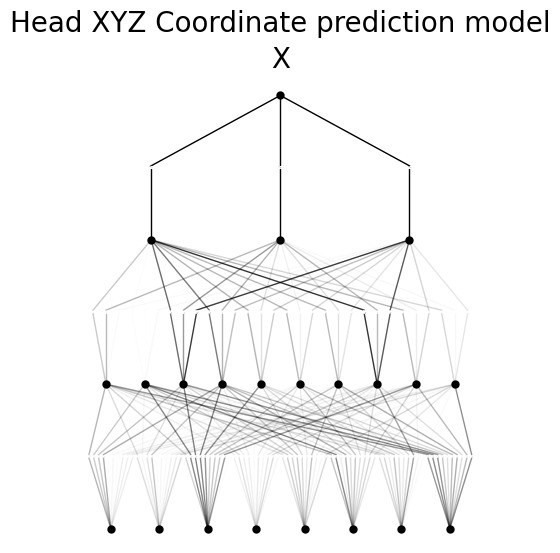

In [17]:
model.plot(beta=2, scale=0.5, out_vars=['X', "Y", "Z"], title="Head XYZ Coordinate prediction model", tick=True)

In [12]:
from torch.utils.data import DataLoader, TensorDataset

test_dataset = TensorDataset(dataset["test_input"], dataset["test_label"])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

predictions = []

with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.append(outputs)

predictions = torch.cat(predictions, dim=0)

c:\Users\geork\projects\AIThesis\src\.venv\lib\site-packages\kan\KAN.py:327: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  self.acts_scale_std.append(torch.std(postacts, dim=0))


     Head_Collision_XYZ_index
0                         117
1                         116
2                         136
3                         106
4                          83
..                        ...
233                        82
234                        93
235                       152
236                       137
237                        80

[238 rows x 1 columns]
<class 'pandas.core.frame.DataFrame'>
Ended
   True_Head_Collision_XYZ_index
0                            117
1                            116
2                            136
3                            106
4                             83
   Predicted_Head_Collision_XYZ_index
0                          117.932587
1                          104.404770
2                          139.101517
3                          102.955711
4                           80.834297


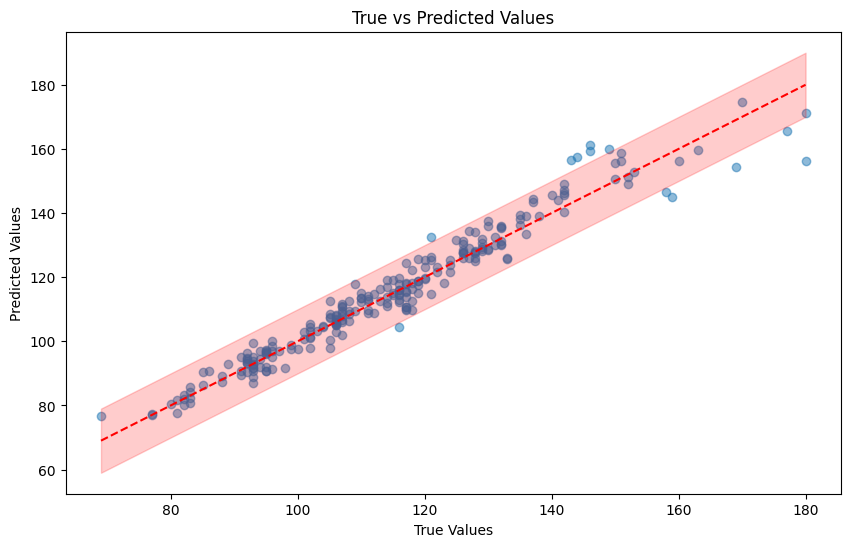

In [15]:
import pandas as pd

# Make predictions
# y_pred = model.predict(X_test)
# Assuming y_test is the true values and y_pred are the predictions

print(y_test)
print(type(y_test))
print("Ended")
y_test = y_test.reset_index(drop=True).rename(columns={'Head_Collision_XYZ_index': 'True_Head_Collision_XYZ_index'})
y_test_df = y_test
y_pred_df = pd.DataFrame(predictions, columns=['Predicted_Head_Collision_XYZ_index'])

# Merge true and predicted values into a single DataFrame
comparison_df = pd.concat([y_test_df, y_pred_df], axis=1)

error_range = 10  # 25 mm on each side of the perfect prediction line

# Plot for the first dimension (X)
# plot_with_error_region( 
#                        comparison_df['True_Head_Collision_X'], 
#                        comparison_df['Predicted_Head_Collision_X'], 
#                        'True vs Predicted Values (Dimension X)')
print(y_test_df.head())
print(y_pred_df.head())
# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(comparison_df['True_Head_Collision_XYZ_index'], comparison_df['Predicted_Head_Collision_XYZ_index'], alpha=0.5)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.plot([comparison_df['True_Head_Collision_XYZ_index'].min(), comparison_df['True_Head_Collision_XYZ_index'].max()], 
         [comparison_df['True_Head_Collision_XYZ_index'].min(), comparison_df['True_Head_Collision_XYZ_index'].max()], 
         color='red', linestyle='--')  # Line of perfect prediction

             # Plot shaded error region
plt.fill_between([comparison_df['True_Head_Collision_XYZ_index'].min(), comparison_df['True_Head_Collision_XYZ_index'].max()], 
                [comparison_df['True_Head_Collision_XYZ_index'].min() - error_range, comparison_df['True_Head_Collision_XYZ_index'].max() - error_range],
                [comparison_df['True_Head_Collision_XYZ_index'].min() + error_range, comparison_df['True_Head_Collision_XYZ_index'].max() + error_range],
                color='red', alpha=0.2)  # Light red shaded region
plt.show()